<a href="https://colab.research.google.com/github/vimesh630/Spice_Price_Predction_VERGER/blob/Cinnamon/Preprocessing_for_Cinnamon_Price_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Mount Google Drive and Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Load Dataset from Google Drive

In [3]:
file_path = "/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_New_0001.xlsx"
df = pd.read_excel(file_path, sheet_name='Sheet1')

print(f"Original dataset shape: {df.shape}")

Original dataset shape: (2772, 16)


#3. Keep Only Active Grade x Region Pairs

In [4]:
df = df[df['Is_Active_Region'] == 1].copy()
print(f"After filtering active regions: {df.shape}")

After filtering active regions: (2244, 16)


#4. Ensure Month Column is datetime

In [5]:
if not np.issubdtype(df['Month'].dtype, np.datetime64):
    df['Month'] = pd.to_datetime(df['Month'], errors='coerce')

#5. Fill Missing Regional Prices

In [6]:
df['Regional_Price'] = df.groupby(['Grade', 'Region'])['Regional_Price']\
    .transform(lambda x: x.interpolate(method='linear').fillna(x.mean()))  # fill with mean if still NaN
df['Regional_Price'] = df['Regional_Price'].fillna(df['National_Price'])

#6. Fill Missing Numeric Features

In [7]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Regional_Price' in numeric_cols:
    numeric_cols.remove('Regional_Price')  # exclude target

for col in numeric_cols:
    df[col] = df.groupby(['Grade', 'Region'])[col]\
                .transform(lambda x: x.ffill().bfill())

#6. Create Date-Based Features

In [8]:
df['year'] = df['Month'].dt.year
df['month'] = df['Month'].dt.month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

#7. Create lag and rolling Features

In [9]:
# === Lags ===
for lag in [1, 2, 3, 6, 12]:
    df[f'price_lag_{lag}'] = df.groupby(['Grade', 'Region'])['Regional_Price'].shift(lag)

# === Rolling stats ===
for window in [3, 6, 12]:
    df[f'price_roll_mean_{window}'] = df.groupby(['Grade', 'Region'])['Regional_Price']\
        .shift(1).rolling(window).mean()
    df[f'price_roll_std_{window}'] = df.groupby(['Grade', 'Region'])['Regional_Price']\
        .shift(1).rolling(window).std()

#8. Log Transform of Price

In [10]:
df['log_price']=np.log1p(df['Regional_Price'])

#9. Relative % Change

In [11]:
for lag in [1, 3, 6, 12]:
    df[f'price_pct_change_{lag}'] = df.groupby(['Grade', 'Region'])['Regional_Price']\
        .pct_change(lag)

#10. Price Shock Indicator (large jump/drop)

In [12]:
df['price_shock_flag'] = (df['price_pct_change_1'].abs() > 0.15).astype(int)

#11. Momentum (sum of last n% changes)

In [13]:
for window in [3, 6]:
    df[f'momentum_{window}'] = df.groupby(['Grade', 'Region'])['price_pct_change_1']\
        .rolling(window).sum().reset_index(level=[0,1], drop=True)

#12. Crisis Period Dummy

In [14]:
df['crisis_flag'] = ((df['Month'] >= '2021-06') & (df['Month'] <= '2022-12')).astype(int)

#13. Interaction Terms

In [15]:
df['region_month'] = df['Region'].astype(str) + "_" + df['month'].astype(str)
df['grade_region'] = df['Grade'].astype(str) + "_" + df['Region'].astype(str)

#14. Categorical Encoding

In [16]:
df['Grade'] = df['Grade'].astype('category')
df['Region'] = df['Region'].astype('category')
df['region_month'] = df['region_month'].astype('category')
df['grade_region'] = df['grade_region'].astype('category')

#15. Final Clean

In [17]:
df = df.dropna().reset_index(drop=True)
print(f"Final dataset shape after dropping NaNs: {df.shape}")

Final dataset shape after dropping NaNs: (1836, 42)


#16.  Save

In [18]:
output_path = "/content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_Preprocessed_CrisisAware.csv"
df.to_csv(output_path, index=False)
print(f"Preprocessed dataset saved to: {output_path}")

Preprocessed dataset saved to: /content/drive/MyDrive/VERGER/Cinnamon_Price_Prediction/Cinnamon_Dataset_Preprocessed_CrisisAware.csv


#17. # Price Trends by Grade and Region

/tmp/ipython-input-43731464.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (grade, region), group in df.groupby(['Grade', 'Region']):


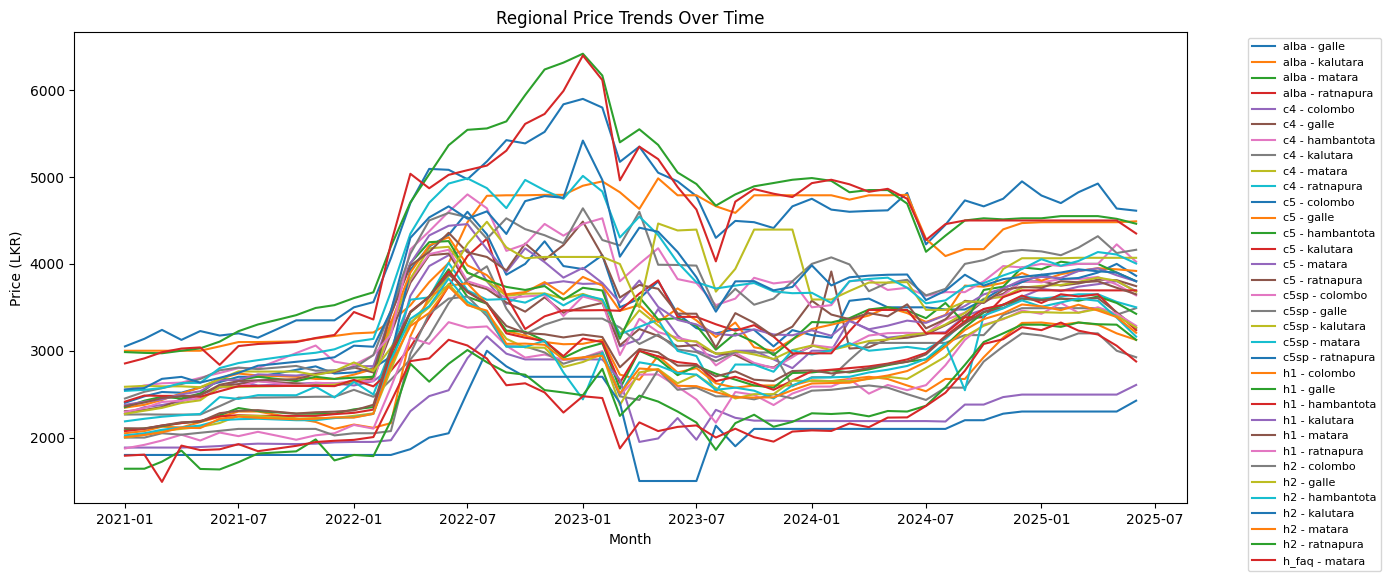

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
for (grade, region), group in df.groupby(['Grade', 'Region']):
    plt.plot(group['Month'], group['Regional_Price'], label=f"{grade} - {region}")
plt.title("Regional Price Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Price (LKR)")
plt.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

#18. Seasonality Plot

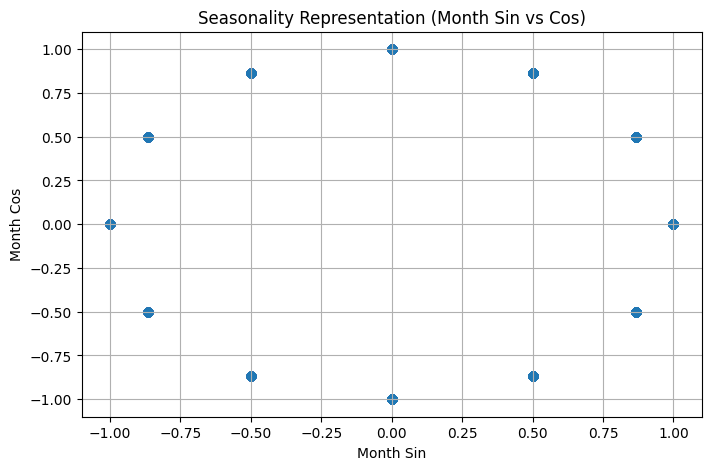

In [20]:
plt.figure(figsize=(8, 5))
plt.scatter(df['month_sin'], df['month_cos'], alpha=0.6)
plt.title("Seasonality Representation (Month Sin vs Cos)")
plt.xlabel("Month Sin")
plt.ylabel("Month Cos")
plt.grid(True)
plt.show()

#19. Distribution of Prices

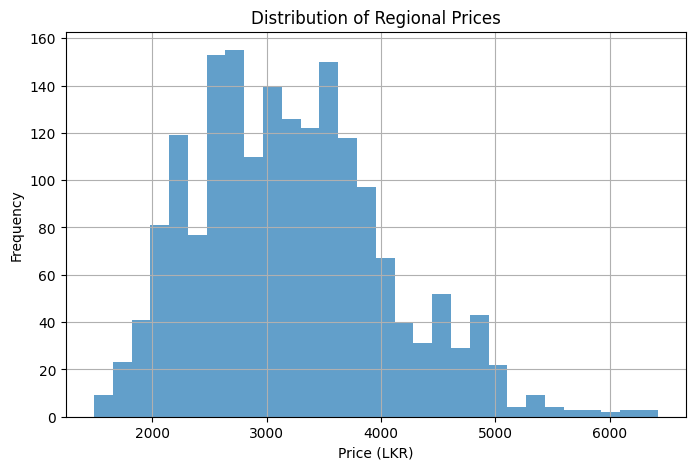

In [21]:
plt.figure(figsize=(8, 5))
df['Regional_Price'].hist(bins=30, alpha=0.7)
plt.title("Distribution of Regional Prices")
plt.xlabel("Price (LKR)")
plt.ylabel("Frequency")
plt.show()

#20. Rolling Statistics Example for One Grde-Region

/tmp/ipython-input-3854525343.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (grade, region), group in df.groupby(['Grade', 'Region']):


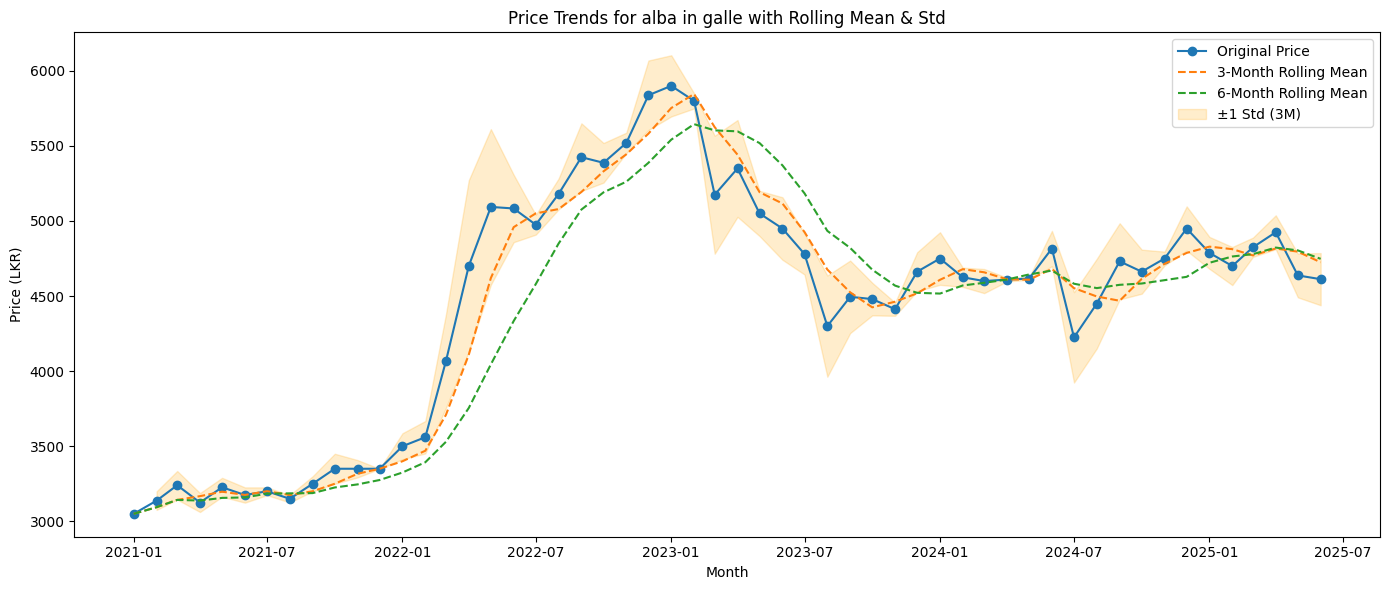

In [22]:
# Ensure Month is datetime
if not np.issubdtype(df['Month'].dtype, np.datetime64):
    df['Month'] = pd.to_datetime(df['Month'])

# Pick the first available Grade-Region pair with enough data
sample_group = None
for (grade, region), group in df.groupby(['Grade', 'Region']):
    if len(group) >= 6:  # at least 6 months of data for rolling mean
        sample_group = group.sort_values('Month')
        break

if sample_group is not None:
    # Compute rolling statistics if they don't exist yet
    sample_group['roll_mean_3'] = sample_group['Regional_Price'].rolling(3, min_periods=1).mean()
    sample_group['roll_mean_6'] = sample_group['Regional_Price'].rolling(6, min_periods=1).mean()
    sample_group['roll_std_3'] = sample_group['Regional_Price'].rolling(3, min_periods=1).std()

    plt.figure(figsize=(14, 6))
    plt.plot(sample_group['Month'], sample_group['Regional_Price'], label="Original Price", marker='o')
    plt.plot(sample_group['Month'], sample_group['roll_mean_3'], label="3-Month Rolling Mean", linestyle='--')
    plt.plot(sample_group['Month'], sample_group['roll_mean_6'], label="6-Month Rolling Mean", linestyle='--')
    plt.fill_between(sample_group['Month'],
                     sample_group['Regional_Price'] - sample_group['roll_std_3'],
                     sample_group['Regional_Price'] + sample_group['roll_std_3'],
                     color='orange', alpha=0.2, label="±1 Std (3M)")
    plt.title(f"Price Trends for {grade} in {region} with Rolling Mean & Std")
    plt.xlabel("Month")
    plt.ylabel("Price (LKR)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No Grade-Region pair found with enough data to plot rolling statistics.")

# Correlations Between Different Attributes

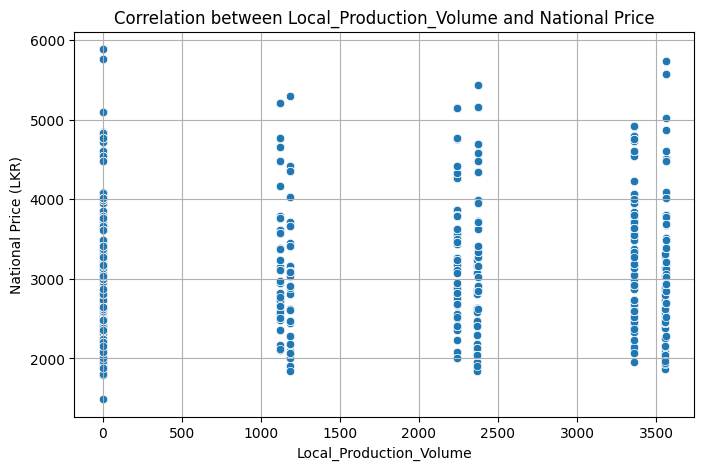

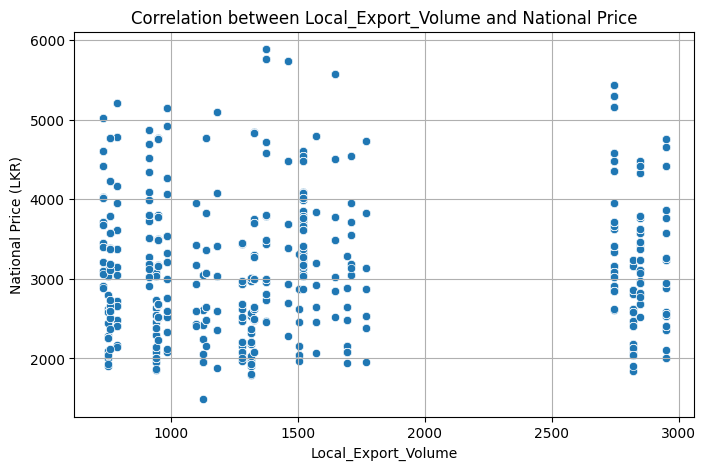

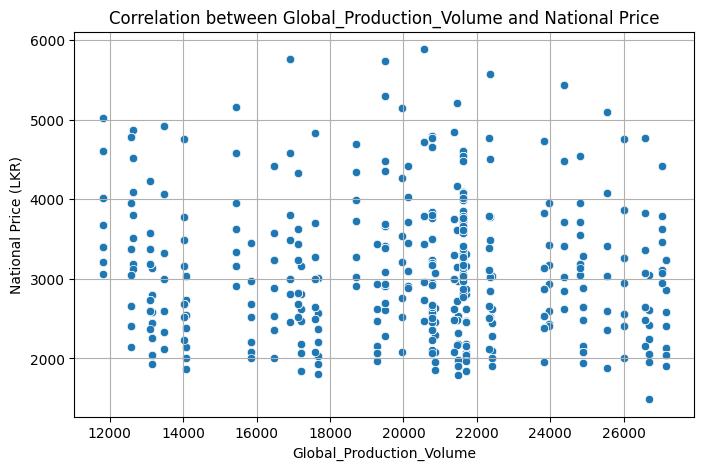

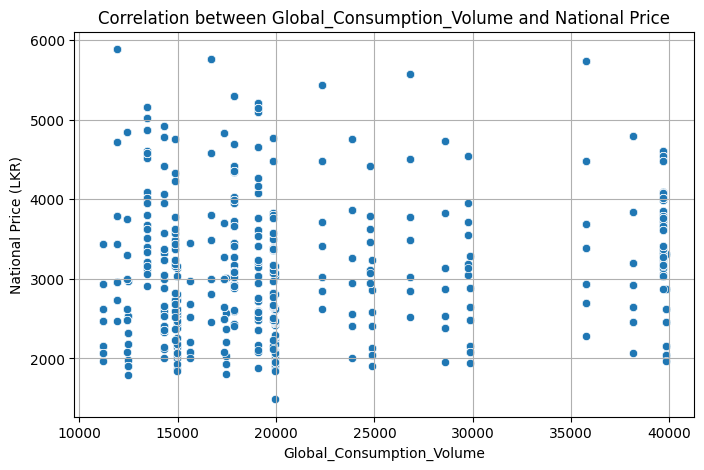

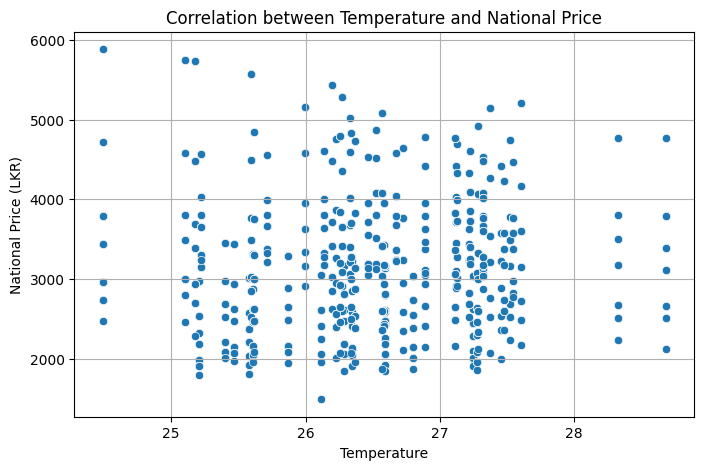

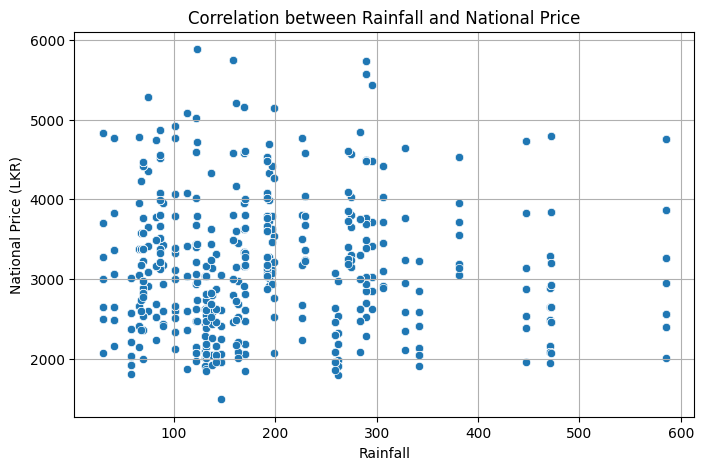

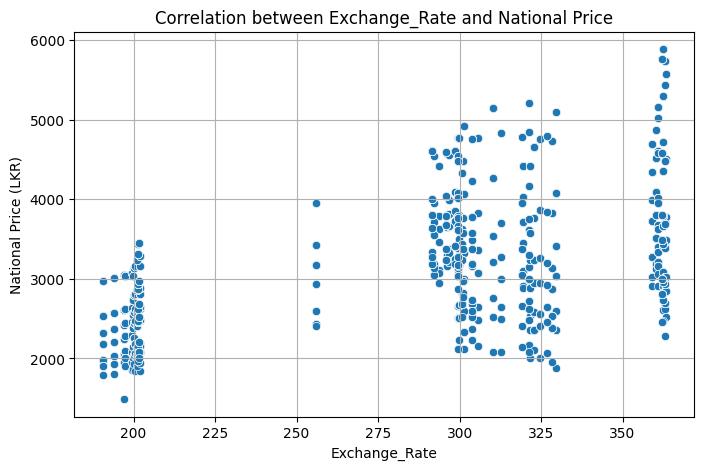

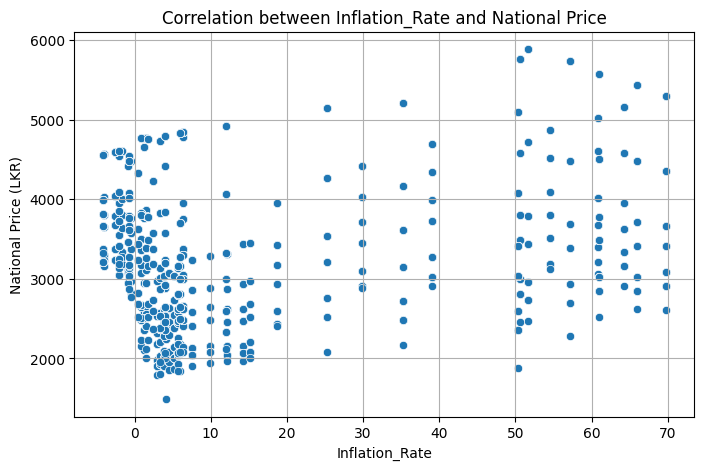

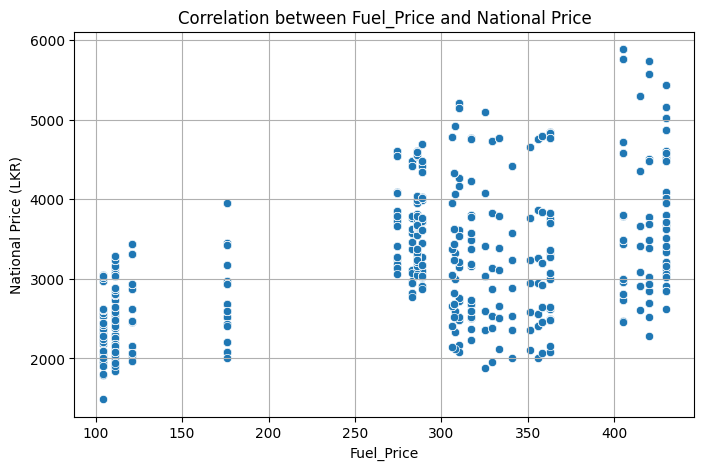

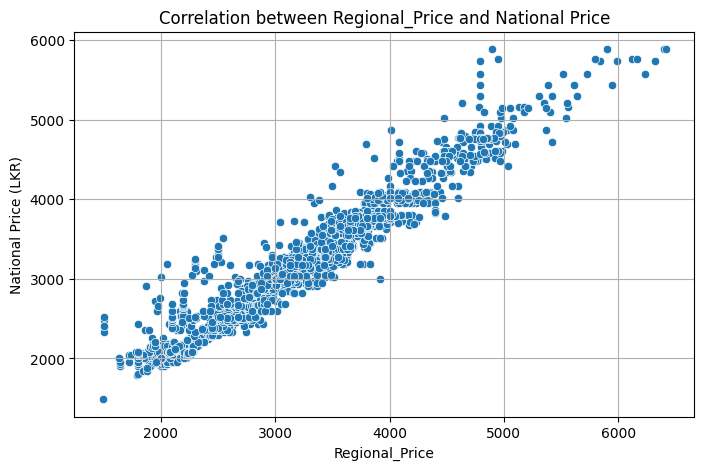

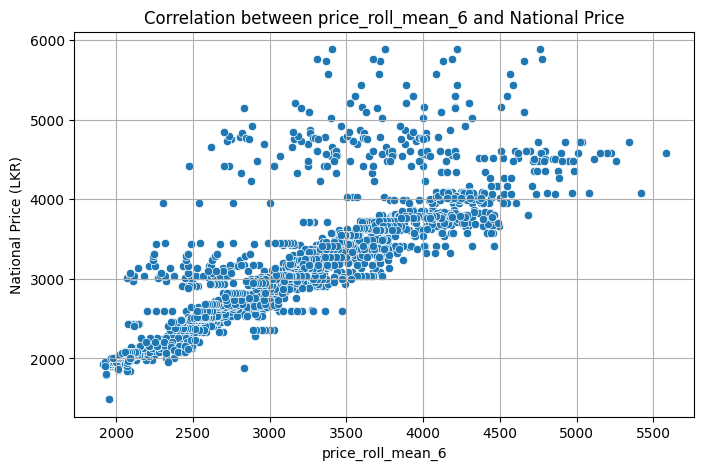

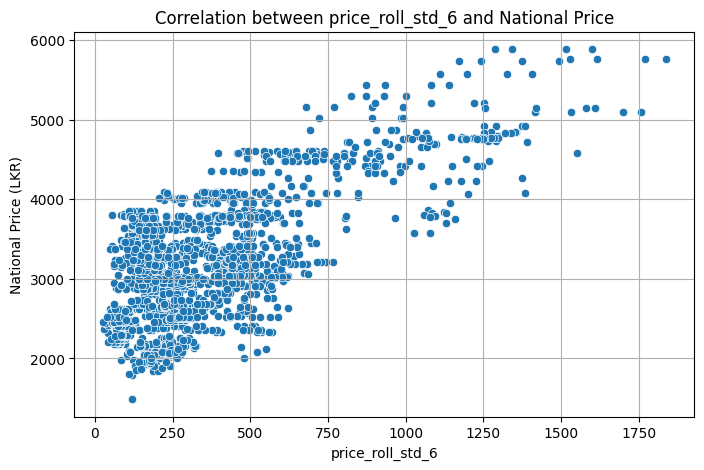

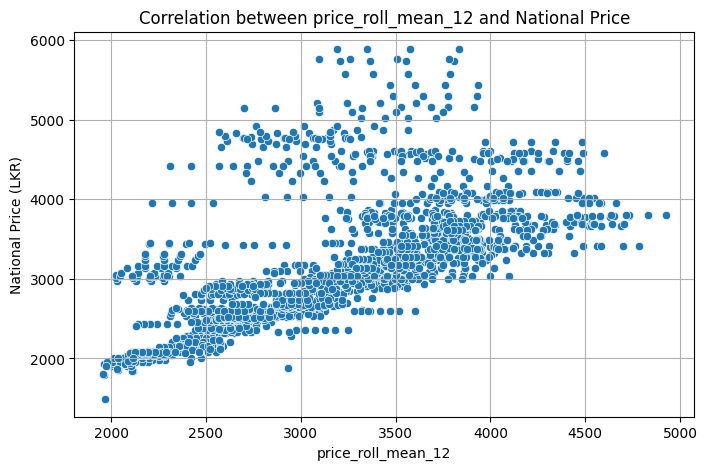

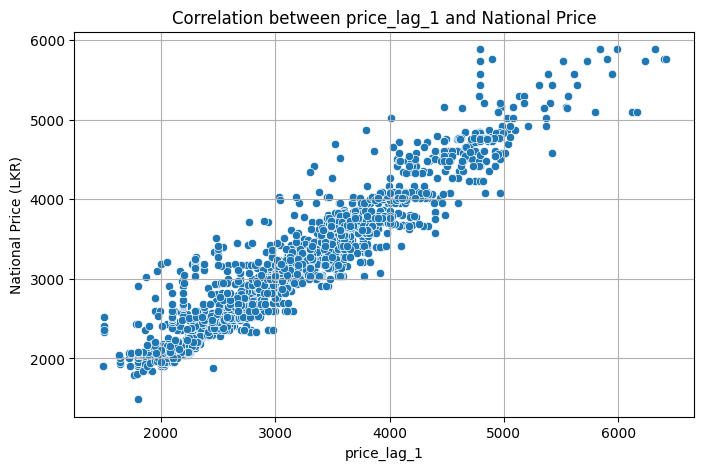

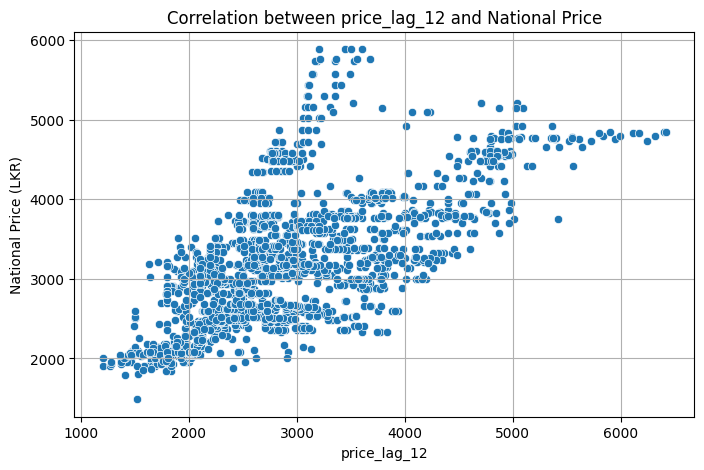

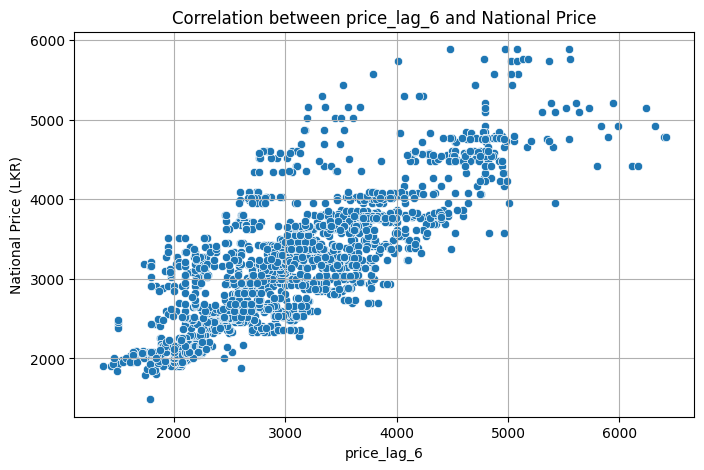

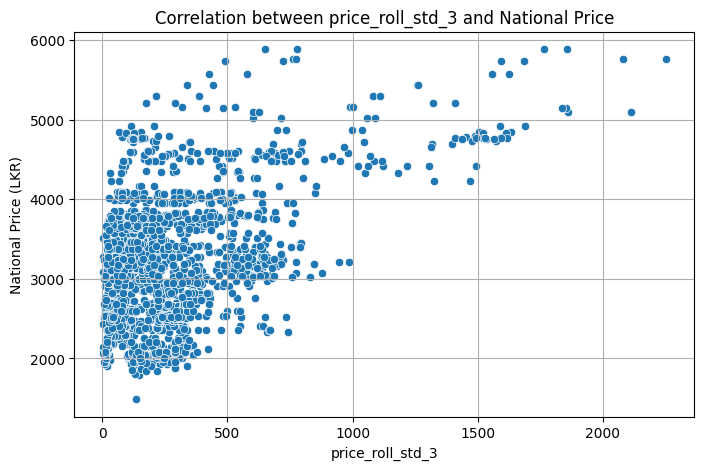

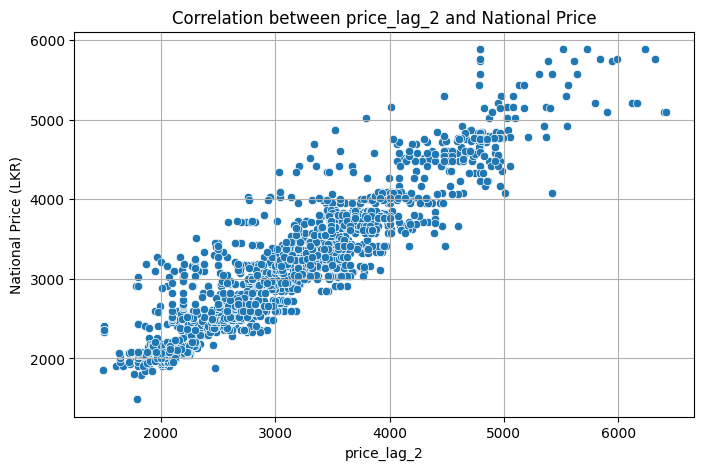

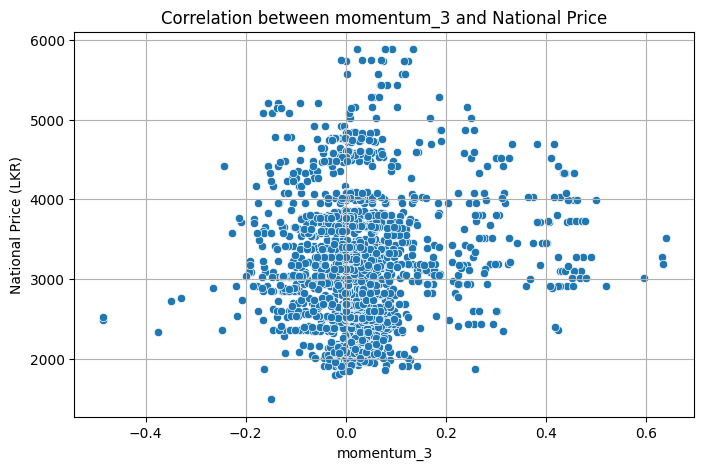

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify features to plot (excluding lag and rolling features and categorical)
features_to_plot = [
     'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
     'Regional_Price','price_roll_mean_6','price_roll_std_6','price_roll_mean_12','price_lag_1','price_lag_12','price_lag_6','price_roll_std_3','price_lag_2','momentum_3'
]

# Create scatter plots for each feature against National_Price
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=feature, y='National_Price')
    plt.title(f'Correlation between {feature} and National Price')
    plt.xlabel(feature)
    plt.ylabel('National Price (LKR)')
    plt.grid(True)
    plt.show()